In [1]:
import pandas as pd
import numpy as np
import timeit
import datetime as dt
from math import exp
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,8)

start_time = dt.datetime.now()

In [2]:
df = pd.read_csv('transactions_clean.csv',index_col=0)
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df['Cardnum'] = df['Cardnum'].apply(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96397 non-null  int64         
 1   Cardnum            96397 non-null  object        
 2   Date               96397 non-null  datetime64[ns]
 3   Merchnum           96397 non-null  object        
 4   Merch description  96397 non-null  object        
 5   Merch state        96397 non-null  object        
 6   Merch zip          96397 non-null  object        
 7   Transtype          96397 non-null  object        
 8   Amount             96397 non-null  float64       
 9   Fraud              96397 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 8.1+ MB


# I. Risk variables - 2

## 1. Day of week

In [4]:
df['Dow'] = df['Date'].dt.day_name()

In [5]:
## we want to not use the oot for target encoding variables
train_test = df[df.Date < '2006-11-01']
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()

In [6]:
y_dow = train_test.groupby('Dow')['Fraud'].mean()

# statistical smoothing
num = train_test.groupby('Dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))
df['Dow_Risk'] = df['Dow'].map(y_dow_smooth)

In [7]:
y_dow=y_dow.reset_index()
y_dow=y_dow.set_index('Dow')
y_dow

,Fraud
Dow,
Friday,0.009788
Monday,0.010095
Saturday,0.018626
Sunday,0.025994
Thursday,0.007127
Tuesday,0.009630
Wednesday,0.008711


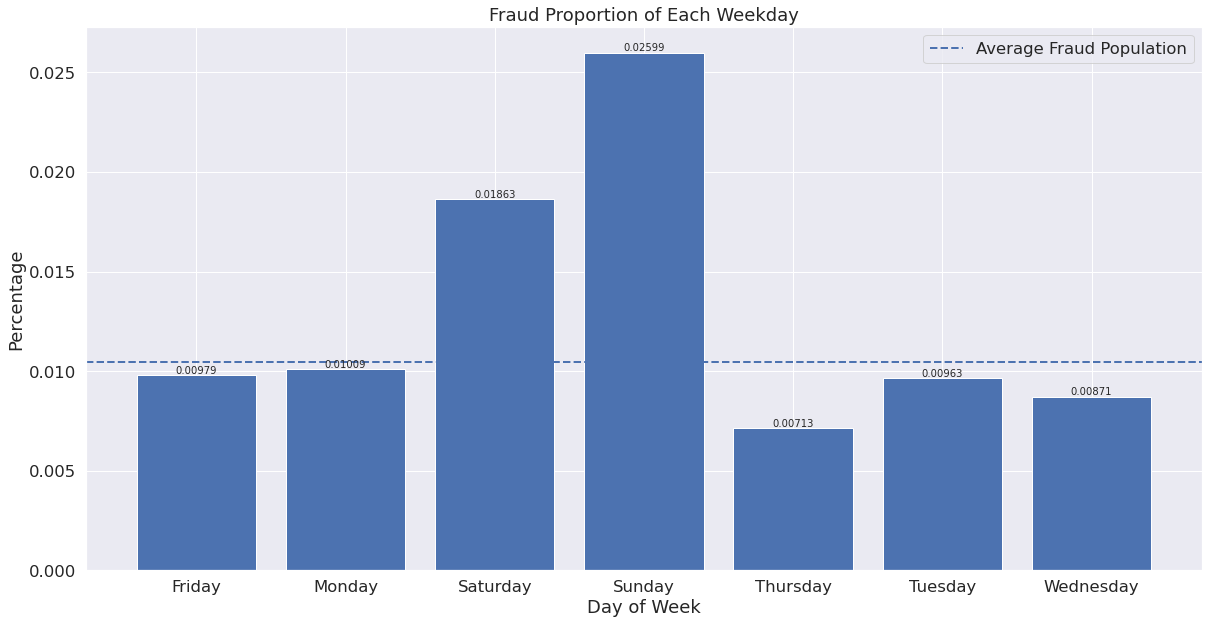

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data = y_dow, x = y_dow.index, height = 'Fraud')
#ax.set_ylim(bottom = 0.013)
ax.axhline(y = y_avg, ls = '--', lw = 2, label="Average Fraud Population")

for i, v in enumerate(y_dow.index):
    ax.text(v,y_dow.loc[v,'Fraud']+0.0001,round(y_dow.loc[v,'Fraud'],5),horizontalalignment='center')

plt.legend()
plt.xlabel("Day of Week")
plt.ylabel("Percentage")
plt.title("Fraud Proportion of Each Weekday")
plt.show()

## 2. Merchant state

In [9]:
y_state = train_test.groupby('Merch state')['Fraud'].mean()

# statistical smoothing
num = train_test.groupby('Merch state').size()
y_state_smooth = y_avg + (y_state - y_avg)/(1 + np.exp(-(num-nmid)/c))
df['state_risk'] = df['Merch state'].map(y_state_smooth)

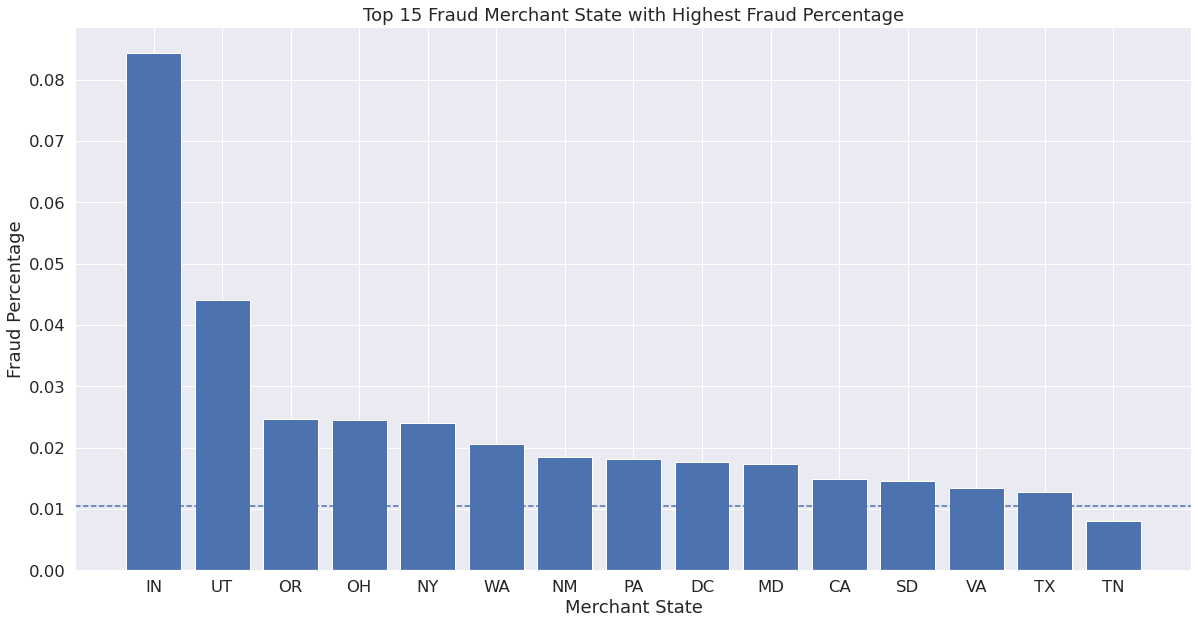

In [10]:
top15_states = pd.DataFrame(y_state.sort_values(ascending=False).head(15))
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data=top15_states, x=top15_states.index, height='Fraud')
plt.title('Top 15 Fraud Merchant State with Highest Fraud Percentage')
plt.xlabel('Merchant State')
plt.ylabel('Fraud Percentage')
ax.axhline(y=y_avg, ls='--')
plt.show()

# II. Create entities

In [11]:
### add leading 0 to zips
### note: there are some zips that are state abbrv. as we imputed them ealier, so pandas read the column as str

# def leading_0(x):
    
#     if '.0' in x:
#         x = x[:-2]
#         if len(x) == 5:
#             return x
#         else: 
#             return '0'*(5-len(x)) + x
#     else:
#         return '0'*(5-len(x)) + x

# df['Merch zip'] = df['Merch zip'].apply(leading_0)

In [12]:
### delete white spaces in merch description
df['Merch description'] = df['Merch description'].str.replace(r'\s', '')

In [13]:
df['card_merch'] = df['Cardnum'] + df['Merchnum']
df['card_zip'] = df['Cardnum'] + df['Merch zip']
# df['card_state'] = df['Cardnum'] + df['Merch state']
df['merch_zip'] = df['Merchnum'] + df['Merch zip']
# df['merch_state'] = df['Merchnum'] + df['Merch state']
# df['state_des'] = df['Merch state'] + df['Merch description']

# these next two entities take a long time to calculate the variables for, and I don't know why
# df['state_zip'] = df['Merch state'] + df['Merch zip']
df['zip3'] = df['Merch zip'].str[:3]

df['card_zip3'] = df.Cardnum + df['zip3']
# df['merchnum_zip'] = df.Merchnum + df['Merch zip']
# df['merchnum_zip3'] = df.Merchnum + df['zip3']

df['Card_Merchdesc'] = df['Cardnum'] + df['Merch description']
# df['Card_dow'] = df['Cardnum'] + df['Dow']
df['Merchnum_desc'] = df['Merchnum'] + df['Merch description']
# df['Merchnum_dow'] = df['Merchnum'] + df['Dow']
# df['Merchdesc_State'] = df['Merch description'] + df['Merch state']
# df['Merchdesc_Zip'] = df['Merch description'] + df['Merch zip']
# df['Merchdesc_dow'] = df['Merch description'] + df['Dow']
df['Card_Merchnum_desc'] = df['Cardnum'] + df['Merchnum'] + df['Merch description']
# df['Card_Merchnum_State'] = df['Cardnum'] + df['Merchnum'] + df['Merch state']
# df['Card_Merchnum_Zip'] = df['Cardnum'] + df['Merchnum'] + df['Merch zip']
# df['Card_Merchdesc_State'] = df['Cardnum'] + df['Merch description'] + df['Merch state']
# df['Card_Merchdesc_Zip'] = df['Cardnum'] + df['Merch description'] + df['Merch zip']
# df['Merchnum_desc_State'] = df['Merchnum'] + df['Merch description'] + df['Merch state']
# df['Merchnum_desc_Zip'] = df['Merchnum'] + df['Merch description'] + df['Merch zip']

In [14]:
df.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'Dow',
       'Dow_Risk', 'state_risk', 'card_merch', 'card_zip', 'merch_zip', 'zip3',
       'card_zip3', 'Card_Merchdesc', 'Merchnum_desc', 'Card_Merchnum_desc'],
      dtype='object')

In [15]:
entities = list(df.iloc[:, np.r_[1, 3, 13:len(df.columns)]].columns)

In [16]:
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'merch_zip',
 'zip3',
 'card_zip3',
 'Card_Merchdesc',
 'Merchnum_desc',
 'Card_Merchnum_desc']

In [17]:
df1 = df.copy()
final = df.copy()
df1['check_date'] = df1.Date
df1['check_record'] = df1.Recnum
numstart = len(final.columns)

# III. Days since and Amount variables - 640

In [18]:
%%time
start = timeit.default_timer()
for entity in entities:    
    try: print(entity,'Run time for the this entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()    

# Day-since variables:   
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record].groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final['Recnum'].map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2006-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')  
    
# Frequency & Amount variables:   
    for time in [0,1,3,7,14,30,60]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')
    del df_l
    del df_r
    del temp
    del temp1
    del temp2
    del mapper2  

print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))



Cardnum_day_since ---> Done
Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_count_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Cardnum_count_60 ---> Done
Cardnum amount variables over past 60 ---> Done
Merchnum Run time for the this entity ----------------- 7.385962917003781s

Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_count_7 ---> Done
Merchnum amount variables over past 7 ---> Done
Merchnum_count_14 ---> Done
Merchnum amount vari

In [19]:
final.shape

(96397, 661)

In [20]:
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

# new variables is  640


# VI. Velocity Variables - 160

In [21]:
%%time
start = timeit.default_timer()
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_count_' + d + '_by_' + dd] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/float(dd)
            final[ent + '_total_amount_'+d+'_by_' + dd]=\
            final[ent +'_total_'+d]/(final[ent+'_total_'+dd])/float(dd)
            
print('run time: {}s'.format(timeit.default_timer() - start))

run time: 2.0365661469986662s
CPU times: user 1.97 s, sys: 68.7 ms, total: 2.04 s
Wall time: 2.04 s


In [22]:
final.shape

(96397, 821)

In [23]:
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

# new variables is  160


# V. Benford's law variables - 2

In [24]:
# split out the first digit of Amount
def first_digit(amount):
    amount = str(amount*100)
    first_d = int(amount[0])
    return first_d
df1['first_digit']=df1.Amount.apply(first_digit)
df1['first_digit'].value_counts(normalize=True)

1    0.275973
3    0.193678
2    0.167827
4    0.085874
5    0.072150
6    0.062419
7    0.052149
8    0.047035
9    0.042896
Name: first_digit, dtype: float64

In [25]:
df1['smallthan_3']=df1.first_digit.apply(lambda x:1 if x < 3 else 0)

In [26]:
%%time

final['is_fedex']=final['Merch description'].str.contains('FEDEX')
c=3
nmid=15
for entity in ['Cardnum','Merchnum']:
  col_name=f'benford_{entity}'
  df_l=df1[['Recnum',entity]]
  df_r=df1[['check_record',entity,'smallthan_3']]
  temp=pd.merge(df_l,df_r,on=entity)
  temp=temp[temp.check_record<=temp.Recnum]

  temp['n']=temp.groupby('Recnum')['smallthan_3'].transform('count')
  temp['n_low']=temp.groupby('Recnum')['smallthan_3'].transform('sum')
  temp['n_high']=temp.n-temp.n_low
  temp['n_low'][temp.n_low==0]=1
  temp['n_high'][temp.n_high==0]=1
  temp['R'] = 1.096*temp.n_low/temp.n_high
  temp['R_inv'] = 1/temp.R
  temp['benford']=temp[['R', 'R_inv']].max(axis=1)
  U=temp[['Recnum','benford']].groupby('Recnum')['benford'].max()
  n=temp.groupby('Recnum').size()
  t=(n-nmid)/c
  mapper=1+(U-1)/(1+np.exp(-t))
  final[col_name]= final.Recnum.map(mapper)
  final[col_name][final.is_fedex==1]=1
final.drop('is_fedex',axis=1,inplace=True)

del U,n,t

CPU times: user 14.1 s, sys: 11.6 s, total: 25.7 s
Wall time: 24.9 s


# VI. Save file for 804 candidate variables

In [27]:
final.set_index('Recnum', inplace = True)
final.shape

(96397, 822)

In [28]:
final.columns

Index(['Cardnum', 'Date', 'Merchnum', 'Merch description', 'Merch state',
       'Merch zip', 'Transtype', 'Amount', 'Fraud', 'Dow',
       ...
       'Card_Merchnum_desc_count_1_by_7',
       'Card_Merchnum_desc_total_amount_1_by_7',
       'Card_Merchnum_desc_count_1_by_14',
       'Card_Merchnum_desc_total_amount_1_by_14',
       'Card_Merchnum_desc_count_1_by_30',
       'Card_Merchnum_desc_total_amount_1_by_30',
       'Card_Merchnum_desc_count_1_by_60',
       'Card_Merchnum_desc_total_amount_1_by_60', 'benford_Cardnum',
       'benford_Merchnum'],
      dtype='object', length=822)

In [29]:
final_vars = final.iloc[:, np.r_[8, 10, 11, 20:len(final.columns)]]

In [30]:
final_vars.head()

,Fraud,Dow_Risk,state_risk,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,Cardnum_total_0,Cardnum_actual/avg_0,...,Card_Merchnum_desc_count_1_by_7,Card_Merchnum_desc_total_amount_1_by_7,Card_Merchnum_desc_count_1_by_14,Card_Merchnum_desc_total_amount_1_by_14,Card_Merchnum_desc_count_1_by_30,Card_Merchnum_desc_total_amount_1_by_30,Card_Merchnum_desc_count_1_by_60,Card_Merchnum_desc_total_amount_1_by_60,benford_Cardnum,benford_Merchnum
Recnum,,,,,,,,,,,,,,,,,,,,,
1,0,0.025994,0.007970,0.0,1,3.62,3.62,3.62,3.62,1.0,...,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.016667,0.016667,1.000000,1.000000
2,0,0.025994,0.003304,0.0,1,31.42,31.42,31.42,31.42,1.0,...,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.016667,0.016667,1.000894,1.000894
3,0,0.025994,0.017282,0.0,1,178.49,178.49,178.49,178.49,1.0,...,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.016667,0.016667,1.000894,1.000894
4,0,0.025994,0.007970,0.0,1,3.62,3.62,3.62,3.62,1.0,...,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.016667,0.016667,1.000000,1.000000
5,0,0.025994,0.007970,0.0,2,3.62,3.62,3.62,7.24,1.0,...,0.142857,0.142857,0.071429,0.071429,0.033333,0.033333,0.016667,0.016667,1.000000,1.000000


In [31]:
final_vars.shape

(96397, 805)

In [32]:
final_vars.to_csv('candidate_variables.csv')

In [33]:
print('Duration: ', pd.datetime.now() - start_time)

Duration:  0:04:55.216574
